In [2]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

Import Data

In [3]:
def to_onehot(x):
    labels = np.unique(x)
    result = np.zeros(shape=(x.shape[0], labels.shape[0]))

    for i in range(len(x)):
        result[i][x[i]] = 1.0

    return result


def generate_feature_cover(X, std_tol = 500):
    x_mean = np.mean(X, axis = 0)
    x_std = np.mean(X, axis = 0)
    feature_cover = np.zeros(len(x_mean), dtype = bool)

    for i in range(len(x_mean)):
        if np.abs(x_std[i]) > std_tol:
            feature_cover[i] = True    

    return feature_cover


def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
   
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Further splitting the training data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size / (1 - test_size),
                                                      random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

In [4]:
training_data = [] # Features per class
training_labels = [] # Labels
testing_data = [] # Features per class
testing_labels = [] # Labels
N = 5250 # Amount of data we want to use max: 5250

# Import the features
with open("traindata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        training_data.append(features)

with open("testdata.txt", "r") as file:
    for line in file.readlines():
        features = [float(i) for i in line.split(",")]
        testing_data.append(features)


# Import the labels
with open("trainlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        training_labels.append(label)

with open("targetlabels.txt", "r") as file:
    for line in file.readlines():
        label = float(line.rstrip())
        testing_labels.append(label)

# Convert data to numpy arrays
# X = np.array(training_data)
# y = to_onehot(np.array(training_labels, dtype=np.int64))

# feature_cover = generate_feature_cover(X, 1000)

X_train = np.load("augmented_traindata.npy")
y_train = to_onehot(np.load("augmented_trainlabels.npy"))

X_test, X_val, y_test, y_val = train_test_split(np.array(testing_data), to_onehot(np.array(testing_labels, dtype=np.int64)), test_size=0.5, random_state=42)

Preprocess Data

In [5]:
# Calculates the number of components to consider when performing pca
def num_components(X, variance_tol = 0.8):
    # Standardize each feature of the matrix
    x_mean = np.mean(X, axis = 0)
    x_std = np.std(X, axis = 0)
    Z = (X - x_mean) / x_std

    # Calculate covariance matrix
    C = np.cov(Z, rowvar=False)
    # Calculate eigenvalues and eigenvectors and sort by size
    eigenvalues, eigenvectors = np.linalg.eig(C)
    index = eigenvalues.argsort()[:: -1]
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:, index]

    # Calculate explained variance matrix 
    explained_var = np.cumsum(eigenvalues) / np.sum(eigenvalues)

    # Select number of components responsible for variance_tol% of variance
    n_components = np.argmax(explained_var >= variance_tol) + 1
    return Z, x_mean, x_std, n_components

# Parameters are trained components, trained mean, trained standard deviation and the new inputs X
# Changes to the PCA basis
def convert_to_pca(components, mean, std, X):
    Z = (X - mean)/std
    return Z @ components.transpose()

Z, mean, std, n_components = num_components(X_train, 0.70)
# Initialize prinicipal component analysis
pca = PCA(n_components, random_state=453)
pca.fit(Z)
components = pca.components_
X_train_PCA = pca.transform(Z)
temp = pca.transform(X_test)
X_test_PCA = convert_to_pca(components, mean, std, X_test)
X_val_PCA = convert_to_pca(components, mean, std, X_val)

In [6]:
np.save("pca_utils/pca_components", components)
np.save("pca_utils/X_mean", mean)
np.save("pca_utils/X_std", std)

In [7]:
print(X_train_PCA.shape)

(5922, 63)


Build Model

In [8]:
import torch as T
import torch.nn as nn


class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs, n_outputs, p_dropout=0.20, save_dir="./models"):
        super(NeuralNetwork, self).__init__()
        self.save_dir = save_dir

        activation = nn.ReLU()
        dropout = nn.AlphaDropout(p=p_dropout)

        self.network = nn.Sequential(
            nn.Linear(in_features=n_inputs, out_features=1024),
            activation,
            dropout,
            nn.Linear(in_features=1024, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=n_outputs),
        )
    
    def forward(self, X):
        logits = self.network(X)
        return logits
    
    def save(self, name):
        T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

    def load(self, name):
        self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))

n_inputs = X_train_PCA.shape[1] # 140 inputs
n_outputs = 21 # 21 labels

# Move a tensor to the GPU
device = T.device("cuda" if T.cuda.is_available() else "cpu")

# Initialize the model
model_1 = NeuralNetwork(n_inputs=n_inputs, n_outputs=n_outputs, p_dropout=0.4).to(device)
model_2 = NeuralNetwork(n_inputs=n_inputs, n_outputs=n_outputs, p_dropout=0.4).to(device)


## Ensembling

In [9]:
class Ensemble(nn.Module):
    def __init__(self, model_1, model_2, n_inputs, n_outputs, save_dir="./models"):
        super(Ensemble, self).__init__()
        self.save_dir = save_dir

        self.model_1 = model_1
        self.model_2 = model_2

        activation = nn.ReLU()
        dropout = nn.Dropout(p=0.4)

        self.classifier = nn.Sequential(
            activation,
            nn.Linear(in_features=n_inputs, out_features=256),
            activation,
            dropout,
            nn.Linear(in_features=256, out_features=128),
            activation,
            dropout,
            nn.Linear(in_features=128, out_features=n_outputs)
        )
    
    def forward(self, x):
        x_1 = self.model_1(x.clone())
        x_2 = self.model_2(x.clone())

        x = T.cat([x_1, x_2], dim=1)
        logits = self.classifier(x)
        return logits
    
    def save(self, name):
        T.save(self.state_dict(), f"{self.save_dir}/{name}.pth")

    def load(self, name):
        self.load_state_dict(T.load(f"{self.save_dir}/{name}.pth"))


model_1.save_dir = "./best_models"
model_2.save_dir = "./best_models"

#Freeze these models 
model_1.load("NeuralNetwork-1_acc-61.81_loss-0.000009")
for param in model_1.parameters():
    param.requires_grad_(False)

model_2.load("NeuralNetwork-2_acc-61.62_loss-0.000004")
for param in model_2.parameters():
    param.requires_grad_(False)

model = Ensemble(model_1, model_2, 42, 21).to(device)


Train Model

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import torch.nn.functional as F

In [11]:
def validate_model(model, X_val, y_val, criterion):
    size = len(y_val)

    model.eval()

    with T.no_grad():
        X = T.from_numpy(X_val).to(T.float32).to(device)
        y_true = T.Tensor(y_val).to(T.float).to(device)

        logits = model.forward(X)

        loss = criterion(logits, y_true)

        y_pred = logits.argmax(1).cpu().numpy()
        y_true = y_true.argmax(1).cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, F.softmax(logits, dim=1).cpu().numpy(), multi_class='ovo')
        loss /= size
        
        print(f"Test Metrics: \n Accuracy: {100 * accuracy:>0.2f}%, Precision: {precision:>0.4f}, Recall: {recall:>0.4f}, ROC AUC: {roc_auc:>0.4f},  Avg loss: {loss:>8f}")
    
    return accuracy, loss

In [12]:
def train_model(model, X_train, y_train, criterion, optimizer):
    size = len(X_train)
    batch_size = 141

    #Prevents model from memorizing the position of data
    indices = np.random.randint(0, size, size)

    model.train()

    for i in range(size//batch_size):
        start = batch_size * i
        end = start + batch_size

        X = T.from_numpy(X_train[indices[start:end]]).to(T.float32).to(device)
        y_true = T.Tensor(y_train[indices[start:end]]).to(T.float).to(device)

        logits = model.forward(X)
        
        loss = criterion(logits, y_true)

        # Gradiant Descent using Adam optimizer for best performance
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct = (logits.argmax(1) == y_true.argmax(1)).type(T.float).sum().item()
        accuracy = correct/batch_size

        if (i * batch_size) % 564 == 0:
            loss, current = loss.item(), (i + 1) * batch_size
            print(f"Accuracy: {(100 * (accuracy)):>0.1f}%, Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [13]:
import torch.optim as optim

# Global Variables
epochs = 1_000
learning_rate = 1e-4

# Load Pre-Trained Models
# model_1.load("NeuralNetwork-1_acc-50.29_loss-0.000003")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

best_accuracy = 0.63 # ???

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")

    train_model(model, X_train_PCA, y_train, criterion, optimizer)
    print('Finished training')
    
    accuracy, loss = validate_model(model, X_val_PCA, y_val, criterion)

    if accuracy > best_accuracy:
        print(f"[+] Saving Model...")
        model.save(f"NeuralNetwork-Ensemble-Advance_acc-{accuracy * 100:.2f}_loss-{loss:>8f}")
        best_accuracy = accuracy

        print(f"[!] Models Saved.")

    epoch += 1


Epoch 1
-------------------------------
Accuracy: 3.5%, Loss: 3.116889 [  141/ 5922]
Accuracy: 7.1%, Loss: 3.025473 [  705/ 5922]
Accuracy: 7.1%, Loss: 3.045874 [ 1269/ 5922]
Accuracy: 8.5%, Loss: 2.997155 [ 1833/ 5922]
Accuracy: 9.9%, Loss: 3.022907 [ 2397/ 5922]
Accuracy: 10.6%, Loss: 2.935496 [ 2961/ 5922]
Accuracy: 11.3%, Loss: 2.964807 [ 3525/ 5922]
Accuracy: 12.8%, Loss: 2.839638 [ 4089/ 5922]
Accuracy: 22.0%, Loss: 2.790448 [ 4653/ 5922]
Accuracy: 17.7%, Loss: 2.803277 [ 5217/ 5922]
Accuracy: 21.3%, Loss: 2.749383 [ 5781/ 5922]
Finished training


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Metrics: 
 Accuracy: 47.90%, Precision: 0.5099, Recall: 0.4835, ROC AUC: 0.8742,  Avg loss: 0.001856
Epoch 2
-------------------------------
Accuracy: 28.4%, Loss: 2.714237 [  141/ 5922]
Accuracy: 22.7%, Loss: 2.723353 [  705/ 5922]
Accuracy: 28.4%, Loss: 2.710209 [ 1269/ 5922]
Accuracy: 23.4%, Loss: 2.728848 [ 1833/ 5922]
Accuracy: 31.2%, Loss: 2.586793 [ 2397/ 5922]
Accuracy: 37.6%, Loss: 2.540323 [ 2961/ 5922]
Accuracy: 34.8%, Loss: 2.528656 [ 3525/ 5922]
Accuracy: 40.4%, Loss: 2.508957 [ 4089/ 5922]
Accuracy: 40.4%, Loss: 2.417779 [ 4653/ 5922]
Accuracy: 43.3%, Loss: 2.439190 [ 5217/ 5922]
Accuracy: 53.2%, Loss: 2.305103 [ 5781/ 5922]
Finished training
Test Metrics: 
 Accuracy: 59.14%, Precision: 0.6154, Recall: 0.5905, ROC AUC: 0.9032,  Avg loss: 0.001653
Epoch 3
-------------------------------
Accuracy: 49.6%, Loss: 2.351843 [  141/ 5922]
Accuracy: 42.6%, Loss: 2.380590 [  705/ 5922]
Accuracy: 47.5%, Loss: 2.277666 [ 1269/ 5922]
Accuracy: 56.0%, Loss: 2.318345 [ 1833/ 5922]


Testing Model

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def make_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    
    plt.show()

In [18]:

criterion = nn.CrossEntropyLoss()
def test_model(model, X_test, y_test, criterion):
    size = len(y_test)

    model.eval()
    with T.no_grad():
        X = T.from_numpy(X_test).to(T.float32).to(device)
        y_true = T.Tensor(y_test).to(T.float).to(device)

        logits = model.forward(X)

        loss = criterion(logits, y_true)

        y_pred = logits.argmax(1).cpu().numpy()
        y_true = y_true.argmax(1).cpu().numpy()
        labels = np.unique(y_true)
        
        make_confusion_matrix(y_pred, y_true, labels)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        roc_auc = roc_auc_score(y_true, F.softmax(logits, dim=1).cpu().numpy(), multi_class='ovo')
        loss /= size
        
        print(f"Test Metrics: \n Accuracy: {100 * accuracy:>0.2f}%, Precision: {precision:>0.4f}, Recall: {recall:>0.4f}, ROC AUC: {roc_auc:>0.4f},  Avg loss: {loss:>8f}")

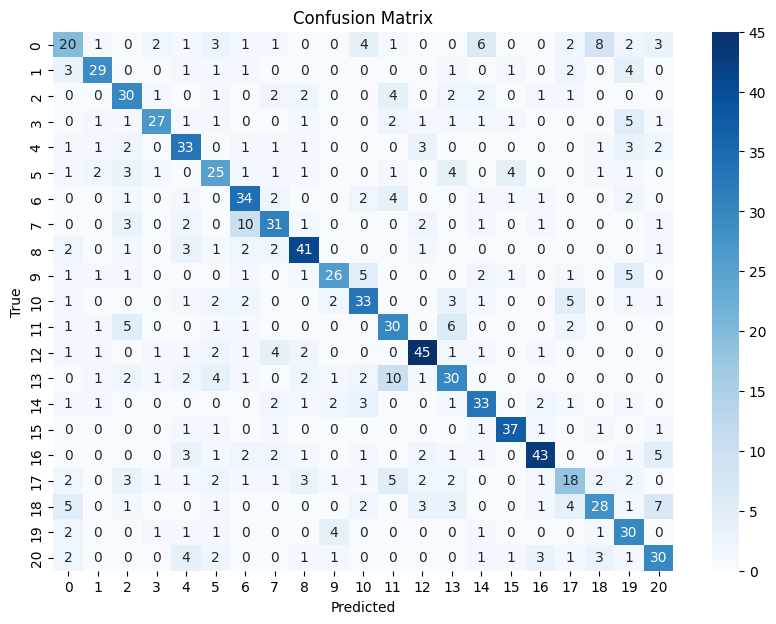

Test Metrics: 
 Accuracy: 62.19%, Precision: 0.6243, Recall: 0.6239, ROC AUC: 0.9070,  Avg loss: 0.006601


In [19]:
# model_1.save_dir = "./best_models"
# model_2.save_dir = "./best_models"

# model.load("NeuralNetwork-Ensemble_acc-62.10_loss-0.005126")
# model_2.load("NeuralNetwork-2_acc-61.81_loss-0.000008")
test_model(model, X_test_PCA, y_test, criterion)